## 회귀 실습 - 캐글 주택 가격 

데이터 다운로드  
https://www.kaggle.com  
house 검색  
train.csv  다운로드 받아서 house_price.csv로 저장

- https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

house_price 데이터 
- 79개의 변수로 구성
- 미국 아이오와 주의 에임즈(Ames) 지방의 주택 가격 정보 데이터

성능 평가는 RMSLE(Root Mean Squared Log Error) 기반

- 가격이 비싼 주택일수록
- 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로
- 이것을 상쇄하기 위해 오류값을 로그 변환한 RMSLE 이용
- RMSE를 하되 예측값과 실제값의 로그 변환값을 기반으로
- RMSE 수행 (RMSLE와 동일 방식)

전체 회귀 분석 과정
- 데이터 전처리
- 선형 회귀 모델 학습/예측/평가
- 회귀 트리 모델 학습/예측/평가
- 회귀 모델의 예측 결과 혼합을 통한 최종 예측
- 스태킹 앙상블 모델을 통한 회귀 예측

### 데이터 전처리

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('./data/house_price.csv')
house_df = house_df_org.copy()
house_df.head()

# Target 값 : SalePrice (마지막 칼럼)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 주요 피처들
- https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

- 1stFlrSF: First Floor square feet  
- 2ndFlrSF: Second floor square feet  
- GrLivArea: Above grade (ground) living area square feet  # 거실면적   
- Bedroom: Bedrooms above grade (does NOT include basement bedrooms)  
- LotArea: Lot size in square feet # 대지크기에 따른 건평   
- GarageArea: Size of garage in square feet   # 차고크기 
- YearBuilt: Original construction date 
- OverallQual: Rates the overall material and finish of the house  
       10	Very Excellent  
       9	Excellent  
       8	Very Good  
       7	Good  
       6	Above Average  
       5	Average  
       4	Below Average  
       3	Fair  
       2	Poor  
       1	Very Poor	

In [2]:
# 데이터 확인
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**데이터 타입과 Null 값 갯수 확인**

In [3]:
house_df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [4]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n', house_df.dtypes.value_counts())

# Null 컬럼 확인 : Null이 있는 컬럼과 그 건수를 내림차순으로 출력
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


#### 결과
- 피처 타입 : 숫자형, 문자형 (43개)
- Null값이 1000개 이상인 데이터도 있음 (drop)

### 회귀 모델 적용하기 전에 타겟 값의 분포도 확인

- SalesPrice의 분포도 확인

<AxesSubplot:title={'center':'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

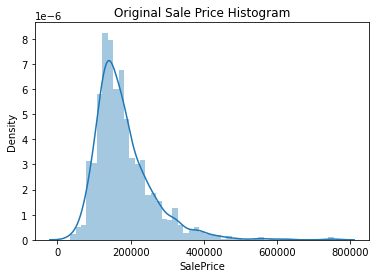

In [5]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

- 데이터의 분포가 중심에서 왼쪽으로 치우친 형태
    - 정규 분포에서 벗어나 있음
- 돈과 관련된 데이터는 log 변환을 진행하면 모델 성능을 높이는 경우가 많음

로그 변환 및 환원
- 정규 분포가 아닌 결과값을 정규 분포 형태로 변환
- log1p() 이용해 로그 변환한 결과값을 기반으로 학습한 후
- 예측 시에는 다시 결과값을 expm1()으로 환원

## log 그래프
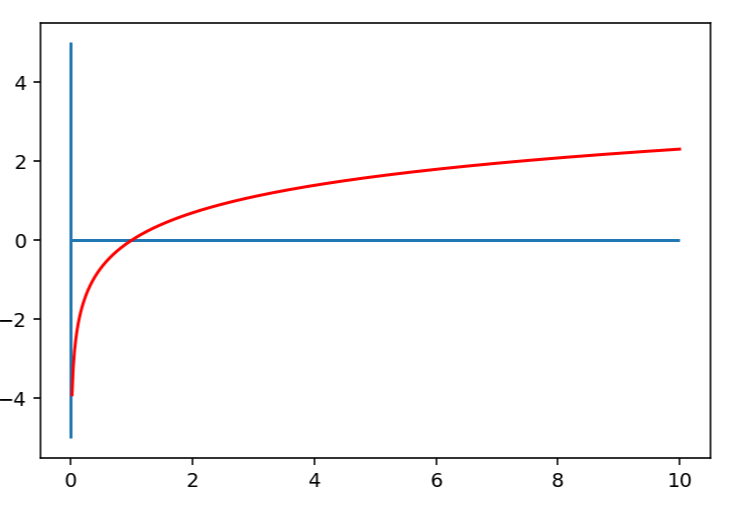

### 로그 그래프의 특징
- 0 < x <1 범위에서는 y축의 기울기가 매우 가파름
    - 즉, 짧은 x의 구간(0,1)에 대해 y의 구간은 매우 큼(-inf~0)
        - x의 값이 0에 가깝게 모이게 되면 y값들은 매우 큰 범위로 벌어지게 됨.  
            즉, 로그함수를 0에 가까운 값들이 모여있는 입력값을 넓은 범위로 펼칠 수 있는 특징이 있음
    - 반면 x의 값이 커지면 로그함수 기울기는 급격히 작아지므로 큰 x값들에 대해서는 y의 값이 크게 차이나지 않게 됨
    - 넓은 범위의 x를 비교적 작은 구간내에 모이게 하는 특징이 있음
- 결과적으로 데이터의 분포를 밀집되어 있는 부분은 퍼지게 퍼져있는 부분은 모아지게 할 수 있다.
    - 이 특성 때문에 한쪽으로 몰려 있는 분포에 로그변환을 취하게 되면 분포가 넓어진다고 할 수 있음


### np.log 변환이 아닌 np.log1 변환을 사용하는 이유

In [6]:
compare = np.array( [0,2.354])
print(np.log(compare))

# 무한대 값이 담긴 배열을 반환, x가 0이면 무한대 값을 갖게됨 (결과 사용 불가)
# 이를 해결하기 위에 데이터에 1을 더한 값을 이용해 log 변환
print(np.log(compare+1))

# log1p 함수는 직접 1을 더하지 않고 함수가 해결함
print(np.log1p(compare))

[      -inf 0.85611601]
[0.         1.21015366]
[0.         1.21015366]


<AxesSubplot:title={'center':'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

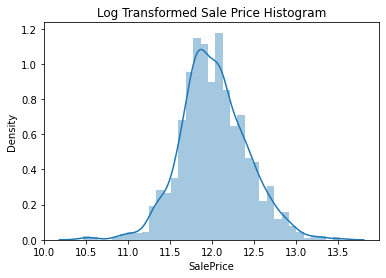

In [7]:
# 결과값을 로그 변환하고 다시 분포도 확인
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

**타겟값인 Price를 로그변환하고 피처들 중 숫자형 컬럼의 Null값 데이터 처리**

In [8]:
# SalePrice 로그 변환
# 원래값 저장 : 다른 독립변수와 관계 등 확인할 때 사용할 수 있으므로 저장
original_SalePrice = house_df['SalePrice']

# 로그변환 값으로 타겟값을 대체
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

In [9]:
# Null이 너무 많은 컬럼들과 불필요한 컬럼 삭제
house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence'], axis=1, inplace=True)

In [10]:
pd.__version__

'1.1.5'

#### pandas의 mean 함수 변경내용(2.x대 버전)
- pd.mean(numeric_only=False) numeric_only=False 기본값 변경됨
- 2.x대 버전은 numeric_only=True로 변경 후 사용

In [11]:
# drop하지 않은 숫자형 Null 컬럼들은 평균값으로 대체
house_df.fillna(house_df.mean(numeric_only=True), inplace=True)

In [12]:
# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
FireplaceQu     object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


### 문자열 변수 처리
- 문자열은 러닝알고리즘에 사용 불가능
    - 수치화 시켜서 주입해야 함
    - 수치화 방법 : label encoding 이나 pd.get_dummies()를 이용해서 인코딩 수행

### **문자열값은 모두 카테고리값이므로 Pandas의 get_dummies( )를 이용하여 원-핫 인코딩 수행**
- 문자열 형태 컬럼에서 나타나는 NaN 값(빈 문자열)은 결측치 자체가 하나의 범주로 처리

In [13]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)

house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

get_dummies() 수행 전 데이터 Shape: (1460, 76)
get_dummies() 수행 후 데이터 Shape: (1460, 276)


In [14]:
house_df_ohe.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


In [15]:
# object 형태 컬럼(문자열 컬럼)은 원-핫 인코딩 진행하고 나면 결측은 없어짐
# 결측도 하나의 범주로 처리되어 버림
null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

## Null 피처의 Type :
 Series([], dtype: object)


### 결측치 전처리 범주형 데이터 인코딩 종료

### 선형 회귀 모델의 학습/예측/평가

LinearRegression, Ridge, Lasso를 이용해 선형 계열의 회귀 모델 만들기

**RMSE 평가 함수 생성**

In [16]:
# 단일 모델의 RMSE 값 반환
def get_rmse(model):  # 학습된 모델을 받아서 예측
    pred = model.predict(x_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)  # 예측값이 이미 log변환 되어짐
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 여러 모델의 RMSE 값 반환
def get_rmses(models) :
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [17]:
# 데이터 분할
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 타깃과 피처
y_target = house_df_ohe['SalePrice']  # 로그변환된 saleprice로 예측
x_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=156)

**모델 학습/예측/평가ㅣ**

In [18]:
# 결측치 처리, 불필요한 데이터 제거, 문자열 데이터 원핫인코딩 타겟변수 로그변환
# 일반 선형 회귀
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)

# 릿지 회귀
ridge_reg = Ridge()
ridge_reg.fit(x_train, y_train)

# 라쏘 회귀
lasso_reg=Lasso()
lasso_reg.fit(x_train, y_train)

Lasso()

In [19]:
# 학습된 모델 전달하고
models = [lr_reg, ridge_reg, lasso_reg] 

# rmse값 반환
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.1321685549276769, 0.12821247260035135, 0.17628250556471392]

### 결과
- 라쏘회귀가 타 회귀 방식보다 상대적으로 성능이 떨어진다.
- 하이퍼 파라미터 튜닝 필요 (alpha 하이퍼파라미티에 대해서 최적화 수행)

**회귀 계수의 시각화**

- 변수가 많으므로 상위10개, 하위 10개의 피처명과 회귀계수값을 반환하는 함수를 작성해서 사용

In [20]:
def get_top_bottom_coef(model) :
    coef = pd.Series(model.coef_, index=x_features.columns)
    
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    
    return coef_high, coef_low

In [21]:
# 모델별 회귀 계수 시각화 함수
# list 객체로 모델을 입력 받아서 모델별로 회귀 계수 상위 10개, 하위 10개 추출 후 가로 막대 그래프 형태로 출력

def visualize_coefficient(models):
    
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)  # 안쪽, 패딩값
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

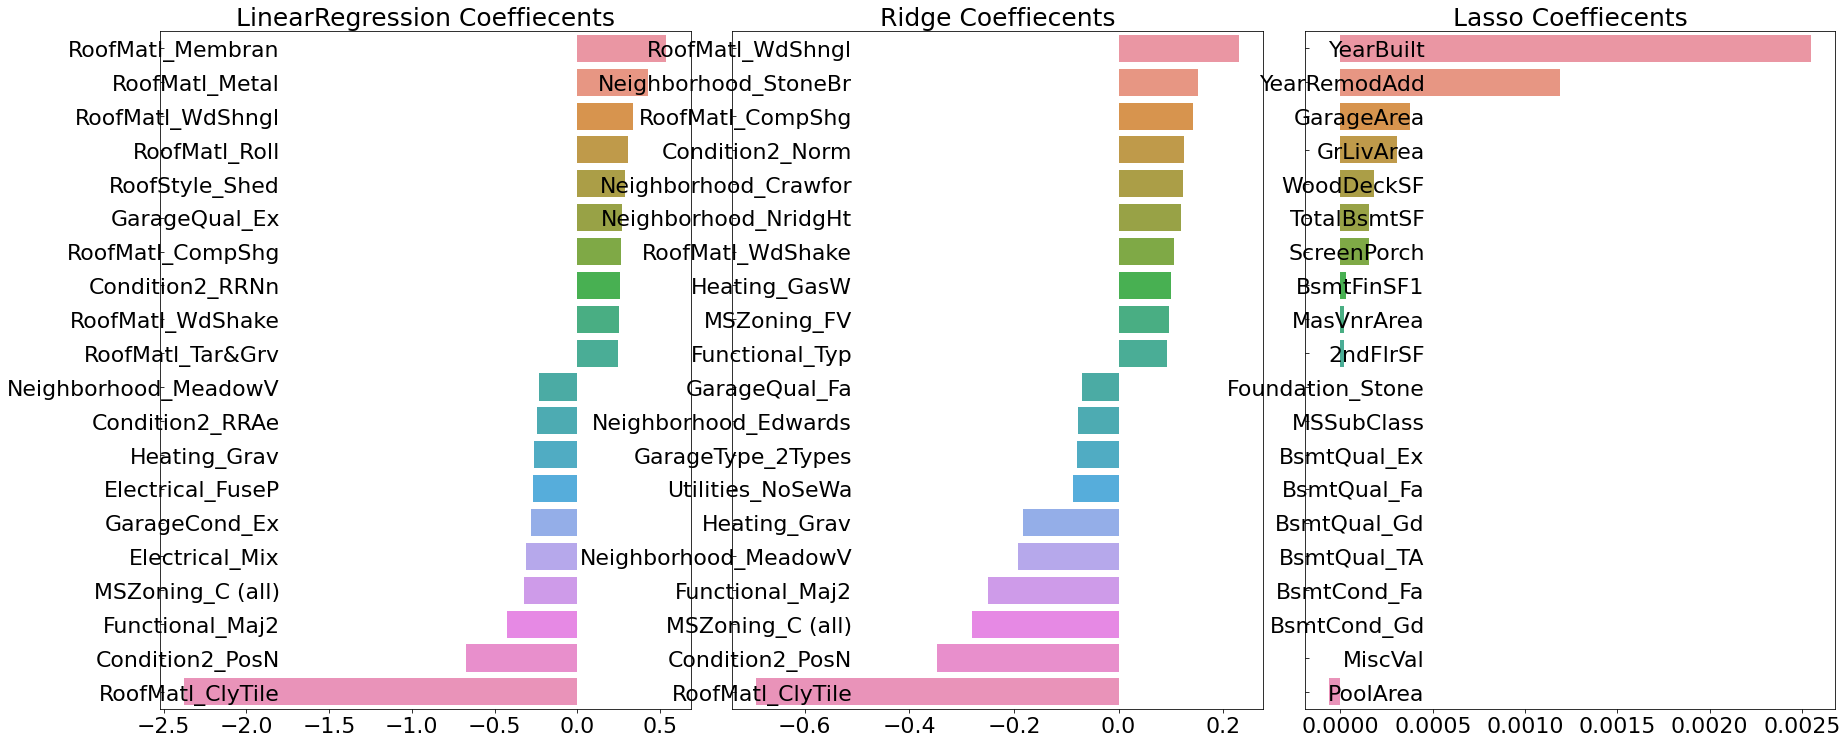

In [22]:
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 결과
- OLS 기반의 LinearRegression과 Ridge : 회귀 계수가 유사한 형태로 분포
- 라쏘 : 전체적으로 회귀 계수 값이 매우 작음.
    - Year Built가 가장 크고, 다른 피처의 회기 계수는 너무 작음
- LinearRegression과 Ridge와 다른 회귀 계수 형태

### 교차검증을 통해 한번 더 확인
- **5 폴드 교차검증으로 모델별로 RMSE와 평균 RMSE 출력**
- 함수 생성

### cross_val_score 라이브러리
- 교차검증 후 평가까지 진행후 결과 반환
    - 반환결과는 폴드수 만큼 반환됨
    - 폴드수 : 교차검증 횟수
    - cross_val_score(model객체, X_train, y_train, scoring=평가지표, cv=폴드수)
    - scoring 파라미터 전달값 중 mse는 neg_mean_squared_error로 정의되어 있음
        - 의미는 mse구해서 음수로 변환한 후 반환
        - 사용하려면 - 추가해서 양수로 변환 후 사용해야 함

In [23]:
from sklearn.model_selection import cross_val_score  # 교차검증 후 평가까지 진행후 결과 반환

def get_avg_rmse_cv(models) :    
    for model in models :
        rmse_list = np.sqrt(-cross_val_score(model, x_train, y_train,
                                    scoring="neg_mean_squared_error", cv=5))       
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))        

In [24]:
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.131 0.126 0.166 0.25  0.147]
LinearRegression CV 평균 RMSE 값: 0.164

Ridge CV RMSE 값 리스트: [0.128 0.118 0.148 0.212 0.148]
Ridge CV 평균 RMSE 값: 0.151

Lasso CV RMSE 값 리스트: [0.182 0.152 0.213 0.28  0.199]
Lasso CV 평균 RMSE 값: 0.205


### 결과
- 5개 폴드 세트로 학습한 후 평가해도
    - 여전히 라쏘 모델이 다른 회귀 모델에 비해 성능이 떨어짐

### **리지/라쏘 모델에 대해 alpha 하이퍼파라미터 튜닝 후 재학습/예측/평가**
- 하이퍼파라미터 튜닝과 교차검증도 같이 진행

- GridSearchCV : 하이퍼파라미터튜닝과 교차검증을 한번에 수행한 후 결과를 반환하는 라이브러리
- GridSearchCV(model, param_grid=하이퍼파라미터를 딕셔너리로 생성해서 전달, scoring, cv)
    - param_grid : 하이퍼파라미터들의 dict
        - ex. params = {파라미터1:[값1,값2,값3], 파라미터2:[값1,값2]}
            - 위 파라미터 값을 조합해서 튜닝
            - 한 조합마다 cv수 만큼 교차검증
    - fit()함수로 학습 시켜서 결과를 반환받아야 함
    - best_score_ 속성 : 가장 높은 지표를 반환
    - best_params_ : 하이퍼파라미터중에 제일 성능이 좋았을때의 파라미터값
    - best_estimator_ : 최적 파라미터로 재 학습된 모델이 저장되어있음

In [25]:
from sklearn.model_selection import GridSearchCV

# 모델과 하이퍼 파라미터 딕셔너리 객체를 받아서 최적화 작업의 결과를 표시하는 함수
# 릿지 모델과 라쏘 모델의 최적화 alpha 값 추출

def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                             scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(x_train, y_train)
    rmse = np.sqrt(-1*grid_model.best_score_) 
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_  # 최적 파라미터로 재학습된 모델 반환

In [26]:
# lasso는 회귀계수를 0으로 만드는 경향이 있으므로 강도를 아주 작게 시작하는 것이 좋다.
ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}

In [27]:
best_ridge = get_best_params(ridge_reg, ridge_params)
best_rasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1498, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1522, 최적 alpha:{'alpha': 0.001}


### 결과(결과 확인 후 정리)
- 릿지 모델 : alpha가  10  에서 최적 평균 RMSE 가  0.151 -> 0.1498
- 라쏘 모델 : alpha가  0.001 에서 최적 평균 RMSE가  0.152
- **라쏘 : alpha 최적화한 후 예측성능이 향상 됨(0.205  -> 0.152 )**

### **재 학습 후 평가**
- 결측치 처리, 불필요한 데이터 제거, 타겟변수 로그변환한 데이터에서 모델 결정

In [28]:
# 결측치 처리, 불필요한 데이터 제거, 타겟변수 로그변환
# 일반 선형 회귀
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)

# 릿지 회귀
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(x_train, y_train)

# 라쏘 회귀
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

Lasso(alpha=0.001)

###  base 모델 결정 
- 위 알고리즘으로 결정
- 선형회귀 알고리즘

In [29]:
# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.125
Lasso 로그 변환된 RMSE: 0.12


[0.1321685549276769, 0.1247886469570372, 0.1203730856170328]

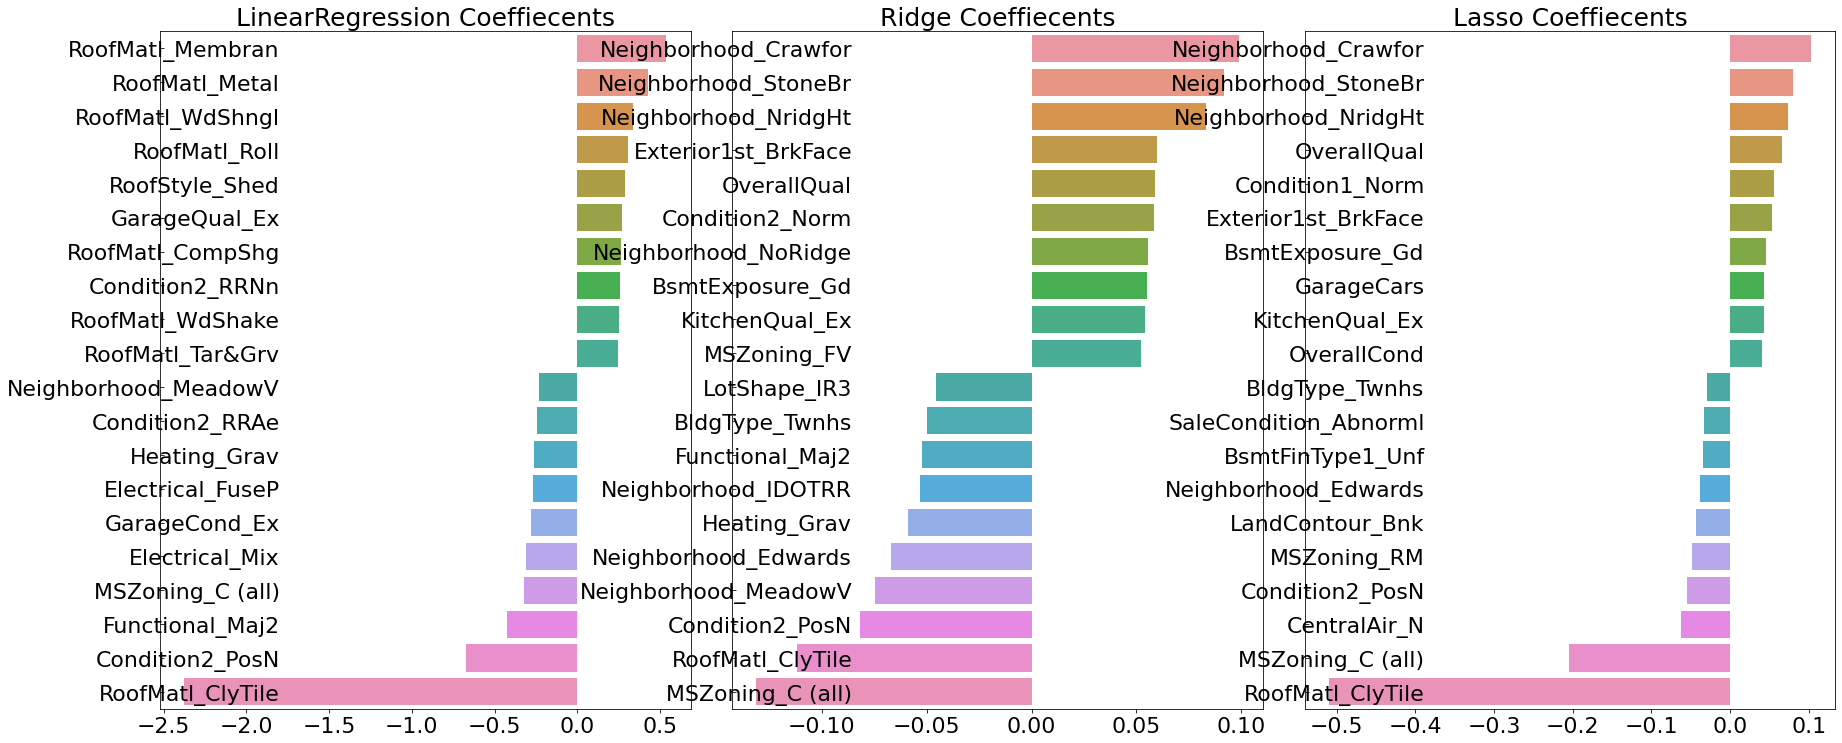

In [30]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

# ridge는 꽤 비슷한 형상으로 나타나는 것 확인 가능

### 데이터 세트를 추가적으로 가공해서 모델 튜닝을 좀 더 진행 
1. 피처 데이터 세트의 데이터 분포도 확인
2. 이상치 데이터 처리

##### 왜곡된 정도 추출 
- 모든 변수를 그래프로 확인 할 수 없으므로 
    - skew() 함수 사용
    - 데이터 분포 왜곡 정도는 수치형 데이터만 확인, 범주형 데이터 확인 필요 X
    - **주의 :** 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 피처 제외

In [31]:
house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,12.429220


In [32]:
house_df.dtypes[house_df.dtypes != 'object'].index

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [33]:
from scipy.stats import skew

# 원-핫 인코딩이 적용되지 않은 house_df 사용
# 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 피처 제외
# house_df에서 object형 피처 제외

features_index = house_df.dtypes[house_df.dtypes != 'object'].index  
# object가 아닌 것만 추출, 해당되는 컬럼 추출

In [34]:
features_index  # 문자열 데이터 제외한 나머지 추출

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [35]:
skew_features = house_df[features_index].apply(lambda x:skew(x))

In [36]:
# skew 정도가 1 이상인 컬럼들만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

# 일반적으로 skew() 함수의 반환값이 1 이상인 경우 왜곡도가 높다고 판단하지만 상황에 따라 편차 있음

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


##### 왜곡이 심한 컬럼에 로그변환 후 재학습/예측/평가

In [37]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [38]:
# 로그 변환 후 다시 왜곡 정도를 확인
skew_features =  house_df[features_index].apply(lambda x:skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

# 여전히 왜곡 정도가 높은 피처가 있지만 더이상 로그변환 하더라도 개선하기 어렵다고 판단 => 그대로 유지하기로 결정

PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
BsmtFinSF2        2.521100
EnclosedPorch     2.110104
dtype: float64


In [39]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 
# 피처/타겟 데이터 세트 다시 생성
# 최적 alpha 값 및 RMSE 출력

# 원-핫 인코딩
house_df_ohe = pd.get_dummies(house_df)

# 피처/타겟 데이터 세트 다시 생성
y_target = house_df_ohe['SalePrice']
x_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

# 학습 데이터와 테스트 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=156)

In [40]:
# 피처들을 로그 변환 했으므로 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1322, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.131, 최적 alpha:{'alpha': 0.001}


In [41]:
# 결측치 제거, 문자열데이터 수치화, 왜도가 심한 독립변수들을 로그변환, 
# 타겟변수 로그변환

# 분할된 학습/테스트 데이터를 이용하여 모델의 학습/예측/평가 및 모델별 회귀 계수 시각화

# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

Lasso(alpha=0.001)

In [42]:
# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.123
Lasso 로그 변환된 RMSE: 0.119


[0.12877719044791708, 0.12330773208755043, 0.11949942324983062]

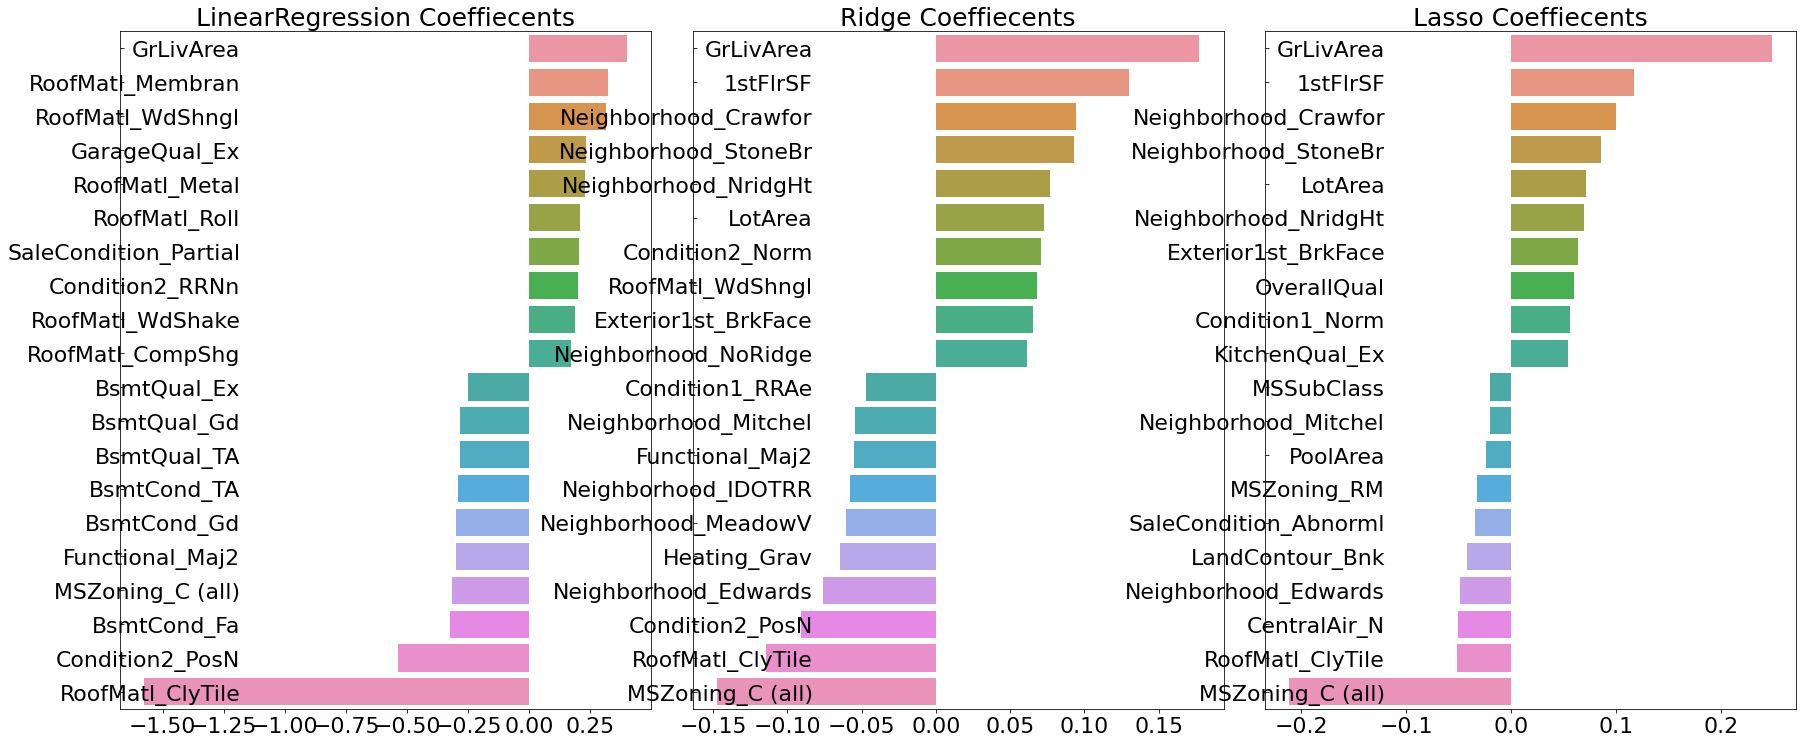

In [43]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 결과  
- 세 모델 모두 GrlivArea(주거공간크기)가 회귀 계수가 가장 높은 피처가 됨
    - 주거공간의 크기가 주택 가격에 미치는 영향이 제일 높다는 의미
    - 상식선에서의 결과 도출

**세 개 모델에서 가장 큰 회귀계수를 가지는 GrLivArea(주거 공간 크기) 피처의 데이터 분포를 살펴봄**
- house_df_org : 최초 원본 데이터, 로그변환 전 타겟값이 들어있음

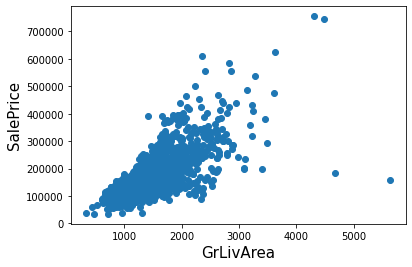

In [44]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

#### 그래프 해석
- 일반적으로 주거 공간이 큰 집일수록 가격이 비싸기 때문에 양의 상관도가 높음을 알 수 있다.  
- but, 오른쪽 아래 2개의 데이터는
    - 일반적인 관계에서 많이 벗어나 있음
    - 크기는 크지만 가격은 매우 낮음 => 이상치로 간주하고 삭제

**이상치 데이터 삭제 후 재 학습/예측/평가**

In [45]:
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

In [46]:
outlier_index  # 주거공간 크기에 비해 집 값이 너무 낮은 관측치, 이상치 처리를 위해 삭제

Int64Index([523, 1298], dtype='int64')

In [47]:
print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0,  inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)  # 1460 -> 1458로 감소, 2개 삭제됨

아웃라이어 레코드 index : [ 523 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 276)
아웃라이어 삭제 후 house_df_ohe shape: (1458, 276)


In [48]:
# house_df_ohe 기반으로 피처/타깃 데이터 세트 다시 생성하고
# 릿지와 라쏘 모델의 최적화 수행

y_target = house_df_ohe['SalePrice']
x_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=156)

In [49]:
# 결측치 제거, 문자열 데이터 수치화, 왜도가 심한 독립변수들을 로그변환, 이상치 처리
# 타겟변수 로그변환 데이터의 결과
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1161, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1154, 최적 alpha:{'alpha': 0.001}


- 이상치를 제거한 데이터 세트를 기반으로 분할된 데이터에 RMSE 수치 및 회귀 계수 시각화

In [50]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
ridge_reg = Ridge(alpha=5)
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

Lasso(alpha=0.001)

In [51]:
# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.105
Lasso 로그 변환된 RMSE: 0.1


[0.12834028292484317, 0.10473543778679723, 0.10017231019821635]

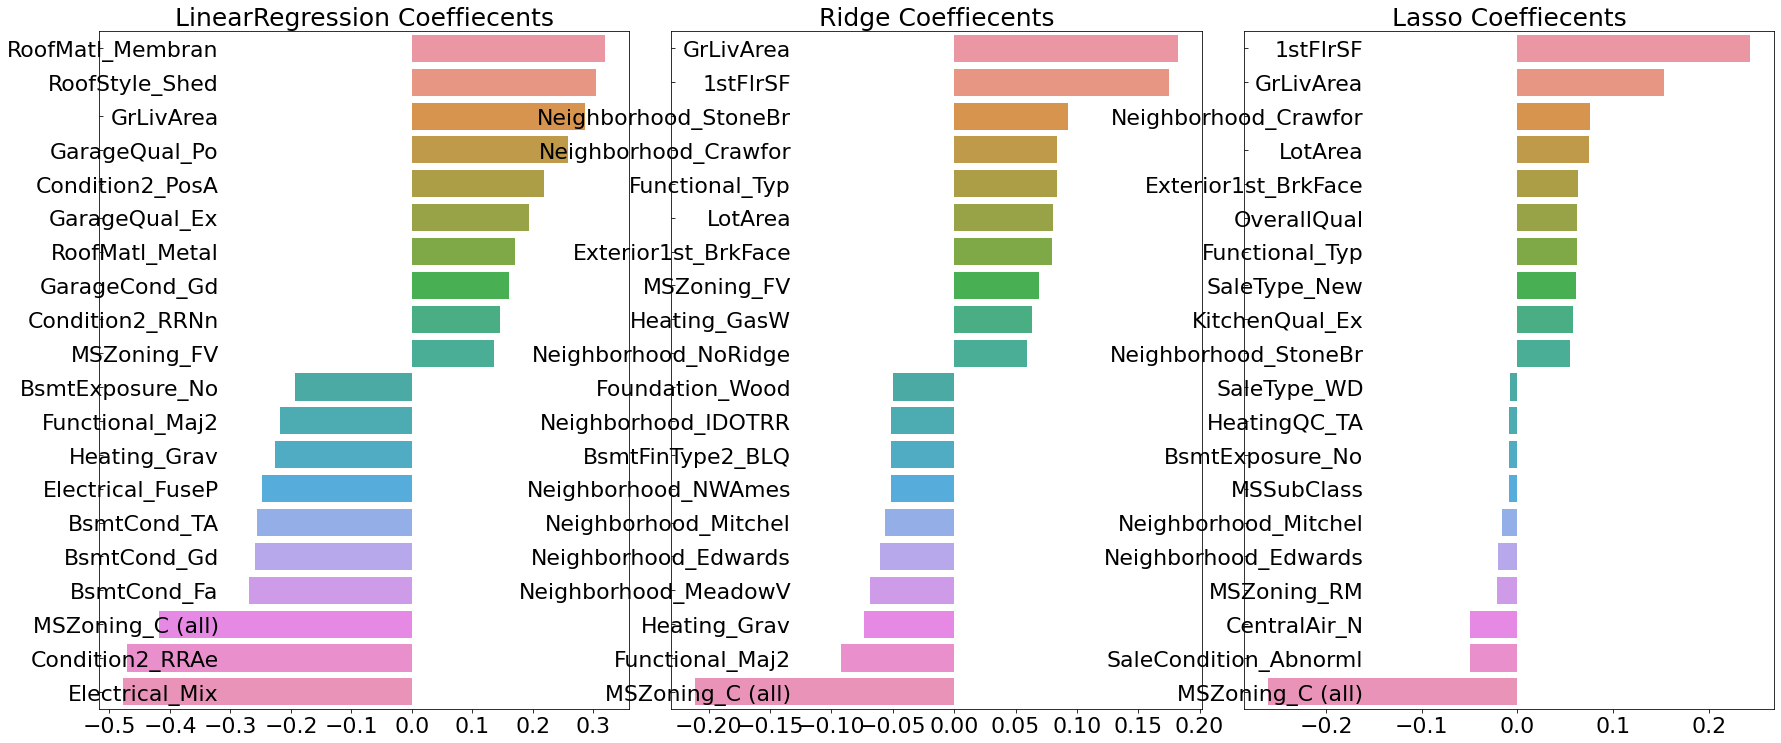

In [52]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

#### 결론
- 이상치 데이터 제거 : 예측수치가 크게 향상됨
    - GrLivArea 속성이 회귀 모델에서 차지하는 영향도 크기 때문에 이상치 제거가 성능개선에 큰 의미를 가진다.
    
- 회귀에서는 중요한 영향을 미치는 피처를 위주로 이상치 데이터를 찾으면 효과가 큼

##### tip.
- 보통 머신러닝 프로세스 중에서 데이터 전처리는 알고리즘 적용 수행하기 이전에 진행하지만 완벽하게 전처리를 수행할 필요는 없음
- 대략의 데이터 가공을 진행하고 모델 최적화를 진행 한 후
    - 결과를 기반으로 다시 여러가지 전처리를 진행하는것이 바람직하다.